# Objetivo
O objetivo deste trabalho é reproduzir o trabalho feito por [Ali Al Bataineh e Devinder Kaur](https://ieeexplore.ieee.org/abstract/document/8556738) e depois introduzir um algoritmo de Feature Selection e analisar o ganho de performance, como custo computacional para treinar o modelo e performance geral. O trabalho será usado como trabalho final na matéria de Inteligência Artificial, ministrada para os alunos da pós em Ciência da Computação pela Universidade Federal de Uberlândia (UFU), em 2021-2.

Alunos: Marcos Tomé, Patrick Araújo e Pedro Reis

# Introdução
A base de dados usada neste estudo chama-se [Boston House Prices](https://www.kaggle.com/vikrishnan/boston-house-prices/version/1) e contém dados oriundos do US Census Service, que levantou o preço de casas na região de Boston, MA em 1970.

A base contém 14 atributos, sendo:

1. CRIM: taxa de crimes per capita na cidade;
2. ZN: proporção de terrenos residenciaiszoneados para lotes com mais de 25.000 pés quadrados;
3. INDUS: proporção de acres de negócios não varejistas na cidade;
3. CHAS: variável que indica áreas tangentes a rios (1 se a área é tangente a um rio, 0 caso contrário);
4. NOX: concentração de óxidos nítricos (em partes por 10 milhões);
5. RM: número médio de quartos por residência;
6. AGE: proporção de unidades ocupadas que foram construídas antes de 1940;
7. DIS: distâncias podenradas para cinco centros comerciais;
8. RAD: índice de acessibilidade às rodovias radiais;
9. TAX: valor total da taxa de imposto sobre a propriedade por U$10.000;
10. PTRATIO: proporção aluno-professor na cidade;
11. B: 1000(Bk - 0.63)² onde Bk é a proporção de negros na cidade;
12. LSTAT: porcentagem da camada inferior da população;
13. MEDV: valor médio das casas ocupadas pelos proprietários em U$1.000.

# Parte 1 - Reprodução do trabalho

In [1]:
import os

if not os.path.exists('tf-levenberg-marquardt'):
    os.system('git clone  https://github.com/fabiodimarco/tf-levenberg-marquardt')

sys.path.append('tf-levenberg-marquardt')

In [2]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import os
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

import levenberg_marquardt as lm

# Pretty display for notebooks
%matplotlib inline

In [3]:
#column names for house features
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

#assigning columns names to our data
data = pd.read_csv("housing.csv", header=None, delimiter=r"\s+", names=column_names)

data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


/home/patrick/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='MEDV', ylabel='Density'>

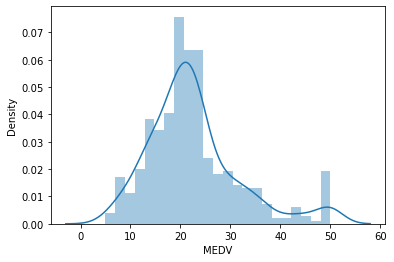

In [4]:
# Visualização da distribuição dos preços dos imóveis
sns.distplot(data['MEDV'])

In [5]:
data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [6]:
# Divisão da base entre treino, validação e teste
# Treino = 
# Validação = 
# Teste = 15%
X = data.drop("MEDV", axis=1)
y = data['MEDV']

np.random.seed(42)

train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

# train is now 75% of the entire data set
# the _junk suffix means that we drop that variable completely
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

print("Treino: ", len(X_train))
print("Validação: ", len(X_val))
print("Teste: ", len(X_test))

Treino:  354
Validação:  76
Teste:  76


In [7]:
# Criação do modelo
model = Sequential()

# Camada de entrada
model.add(Input(shape=(X_train.shape[1],)))

# Camada profunda
model.add(Dense(5, activation='sigmoid'))

#Camada de saída
model.add(Dense(1, activation='linear'))

In [8]:
model.compile(optimizer=tf.keras.optimizers.Adamax(),
              loss='mean_squared_error')



In [45]:
from tensorflow.keras.callbacks import Callback
import warnings

class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=13.1, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

In [46]:
from sklearn.preprocessing import MinMaxScaler

# Fit
model_wrapper = lm.ModelWrapper(model)
model_wrapper.compile(optimizer = tf.keras.optimizers.SGD(),
                      loss = lm.MeanSquaredError(),
                      metrics=['mean_squared_error'])

scaler = MinMaxScaler(feature_range=(0, 1)) 
X_train_edited = scaler.fit_transform(X_train)
X_val_edited = scaler.fit_transform(X_val)

stop_training = EarlyStoppingByLossVal()


model_fitted = model_wrapper.fit(X_train_edited, y_train, #X_train_edited, y_train_edited
                                 epochs=20,
                                 validation_data=(X_val_edited, y_val),
                                 callbacks=[stop_training])

Epoch 1/20
12/12 [==============================] - 1s 45ms/step - damping_factor: 1.0000e-09 - attempts: 1.0000 - loss: 28.1543 - mean_squared_error: 30.9950 - val_loss: 19.5188 - val_mean_squared_error: 19.5188
Epoch 2/20
12/12 [==============================] - 0s 28ms/step - damping_factor: 1.0000e-09 - attempts: 1.0000 - loss: 0.0000e+00 - mean_squared_error: 26.0448 - val_loss: 21.0840 - val_mean_squared_error: 21.0840
Epoch 3/20
12/12 [==============================] - 0s 28ms/step - damping_factor: 1.0000e-09 - attempts: 1.0000 - loss: 0.0000e+00 - mean_squared_error: 30.4824 - val_loss: 18.2682 - val_mean_squared_error: 18.2682
Epoch 4/20
12/12 [==============================] - 0s 28ms/step - damping_factor: 1.0000e-09 - attempts: 1.0000 - loss: 0.0000e+00 - mean_squared_error: 31.0386 - val_loss: 21.3253 - val_mean_squared_error: 21.3253
Epoch 5/20
12/12 [==============================] - 0s 28ms/step - damping_factor: 1.0000e-08 - attempts: 1.0000 - loss: 0.0000e+00 - mean_

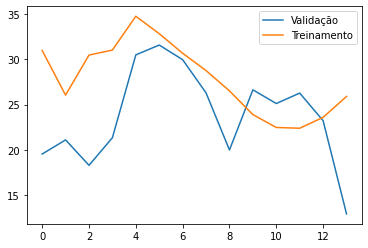

In [60]:
import matplotlib.pyplot as plt 

plt.plot(model_fitted.history['val_mean_squared_error'], label='Validação')
plt.plot(model_fitted.history['mean_squared_error'], label='Treinamento')
plt.legend()